In [1]:
%pylab inline
import numpy as np

import networkx as nx
from utility import ER_GNP, make_SBM, uniform_weight_edges
from sis import simulate_SIS, get_p_curve, get_p_curves, make_raster_plots
import importlib
from manage import (
    rank_by_evec,
    decrease_nodes_weights,
    decrease_top_nodes_weights,
    manage_nodes,
)

Populating the interactive namespace from numpy and matplotlib


# 1. Make Network to Study

In [29]:
np.random.seed(123)

In [30]:
K = 8 # number communities

if K == 4:
    PI = 1/2*np.array([[.1,.05,.00,.00],
                      [.05,.1,.05,.00],
                      [.00,.05,.1,.05],
                      [.00,.001,.05,.1]])

if K == 8:
    PI = 1/4*np.array([[ .1,.05,.01, .0, .0, .0, .0, .0],
                      [.05, .1,.05,.01, .0, .0, .0, .0],
                      [.01,.05, .1,.05,.01, .0, .0, .0],
                      [ .0,.01,.05, .1,.05,.01, .0, .0],
                      [ .0, .0,.01,.05, .1,.05,.01, .0],
                      [ .0, .0, .0,.01,.05, .1,.05,.01],
                      [ .0, .0, .0, .0,.01,.05, .1,.05],
                      [ .0, .0, .0, .0, .0,.01,.05, .1]])


N = 50*K # nodes
Ns = np.ones(K,dtype=int)*N/K
A,id_sets = make_SBM(Ns,PI)
A = uniform_weight_edges(A,.1)

lam = np.max(np.linalg.eigh(A)[0])
lam

0.25046999291840666

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

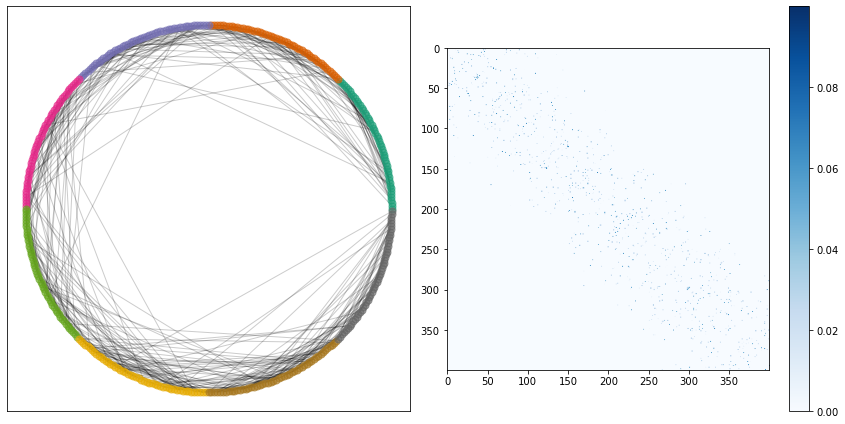

In [31]:
f1,ax = plt.subplots(1,2,figsize = (12,6))
cmap = plt.get_cmap('Dark2')
colors = [cmap(i) for i in range(K)]
#colors = Pastel1#['b','r','g','y']
G = nx.to_networkx_graph(A,create_using=nx.Graph())
pos = nx.circular_layout(G)
for t,ids in enumerate(id_sets):
    nx.draw_networkx_nodes(G,pos,nodelist = ids,ax=ax[0],node_size=50,node_color=colors[t],alpha=.6)
nx.draw_networkx_edges(G,pos,ax=ax[0],edge_size=2,node_color='k',alpha=.2)   
    
temp = ax[1].imshow(A,cmap='Blues')
cbar = plt.colorbar(temp);
plt.tight_layout()

savefig('figs/net_plot.pdf')

# 2. Simulate SIS Epidemics

400

In [5]:
x0 = np.zeros(len(A),dtype=int)
x0[int(len(A)/2)] = 1
T = 10
SIS_opts = {'T':2 * T + 1, # number of discrete time steps
            'x0':x0, # initial condition
            'gamma':0.001, # spreading rate
            'beta':0.01, # recovery rate
            'eta':0.00005 # random activation rate
           }

gamma1 = .02
SIS_opts['gamma'] = gamma1
X1 = simulate_SIS(A,SIS_opts)

gamma2 = .05
SIS_opts['gamma'] = gamma2
X2 = simulate_SIS(A,SIS_opts)

### The critical spreading rate for a pandemic is
$$
\gamma^* = \beta/\lambda
$$
where $\beta$ is the healing rate and $\lambda$ is the largest eigenvalue of matrix $A$, where entry $A_{ij}$ is the spreading rate from patch $j$ to patch $i$.

In [6]:
lam = np.max(np.linalg.eigh(A)[0])
print('epidemic threshold is: ',SIS_opts['beta']/lam)

epidemic threshold is:  0.033101662270896254


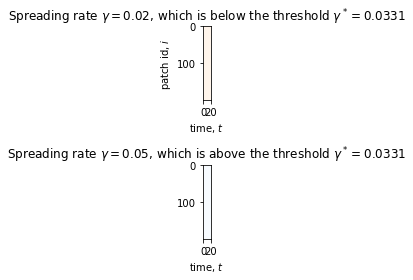

In [7]:
f1,ax = plt.subplots(2,1,figsize=(6,4));
make_raster_plots(ax,[X1,X2])
ax[0].set_title('Spreading rate $\gamma=$'+str(gamma1)+
                ', which is below the threshold $\gamma^*=$'+str(SIS_opts['beta']/lam)[:6])
ax[1].set_title('Spreading rate $\gamma=$'+str(gamma2)+
                ', which is above the threshold $\gamma^*=$'+str(SIS_opts['beta']/lam)[:6])
plt.tight_layout()
plt.savefig('figs/raster.pdf')

## When the spreading rate $\gamma$ surpasses the threshold $\gamma^* = \beta/\lambda$, then the isolated events (which occur at rate $\eta=$) exponentially spread until a steady state fraction is obtained 
$$
p = \lim_{t\to\in} s(t),
$$
where
$$
s(t) = \frac{\text{number of active patches}}{\text{total number of patches} } = \frac{\sum_i x_i(t)}{N}.
$$
Here, $x_i(t)=1$ if patch $i$ is active at time $t$ and $x_i(t)=0$ otherwise.

In [8]:
SIS_opts['T'] = T * 5 # numnber of time steps
gammas = np.logspace(-1,1,20) * SIS_opts['beta']/lam
delay = T # how many time points to ignore before computing average activation
ps = get_p_curve(A,SIS_opts,gammas,delay)

0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95


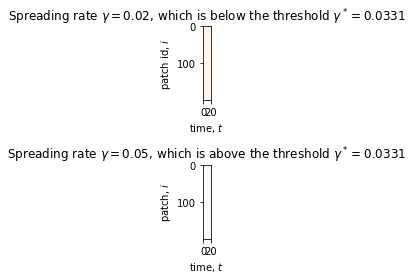

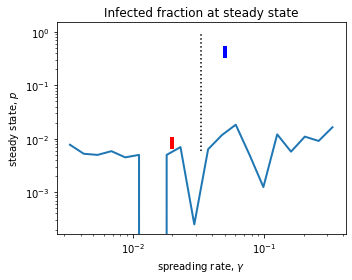

In [9]:
f1,ax = plt.subplots(2,1,figsize=(7,4));
make_raster_plots(ax,[X1,X2])
ax[1].set_ylabel('patch, $i$')
ax[0].set_title('Spreading rate $\gamma=$'+str(gamma1)+
                ', which is below the threshold $\gamma^*=$'+str(SIS_opts['beta']/lam)[:6])
ax[1].set_title('Spreading rate $\gamma=$'+str(gamma2)+
                ', which is above the threshold $\gamma^*=$'+str(SIS_opts['beta']/lam)[:6])
plt.tight_layout();
plt.savefig('figs/raster2.pdf')

f1 = plt.figure(figsize=(5,4));
plt.loglog(gammas,ps,linewidth=2)
plt.title('Infected fraction at steady state')
plt.ylabel('steady state, $p$')
plt.xlabel('spreading rate, $\gamma$')
plt.plot([SIS_opts['beta']/lam,SIS_opts['beta']/lam],[.006,1],'k:')
plt.plot([gamma1,gamma1],[.007,.010],'r',linewidth=4)
plt.plot([gamma2,gamma2],[.35,.5],'b',linewidth=4)
plt.tight_layout();
plt.savefig('figs/phase_transition3.pdf')

In [10]:
# importlib.reload(manage_nodes)

In [50]:
p = 0.7
KK = 64 * 4
Ks = np.arange(0,KK,K)

rank_opts = {'type':'random' # rank completely at random
            }

manage_opts = {'p':p, # decrease the edge weights of selected nodes by p% (p=1 is the strongest management) 
               'online':False, # update ranking after each modification?
               'distributed':False # compute rankings separately for different subgraphs
              }
manage_opts['budget_step'] = K
rank_opts['budget'] = [KK]
rank_opts['control_id_sets'] = [np.arange(len(A))] # global control

A_random,lams_random, Ksr = manage_nodes(A,rank_opts,manage_opts)

In [51]:
manage_opts = {'p':p, # decrease the edge weights of selected nodes by p% (p=1 is the strongest management) 
               'online':True, # update ranking after each modification?
               'distributed':False # compute rankings separately for different subgraphs
              }
manage_opts['budget_step'] = K

rank_opts = {'type':'evec', # rank according to eigenvector centrality
            }
rank_opts['budget'] = [KK]
rank_opts['control_id_sets'] = [np.arange(len(A))] # global control


manage_opts['online'] = True
AA,lams, Ks = manage_nodes(A,rank_opts,manage_opts)

manage_opts['online'] = False
AA2,lams2, Ks2 = manage_nodes(A,rank_opts,manage_opts)


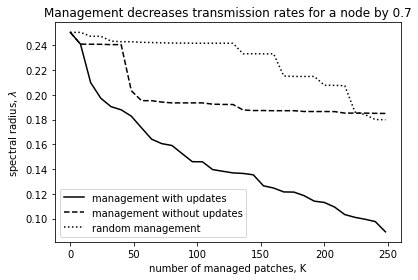

In [52]:
#plot(arange(K),lams[0]*np.ones(K),'k:')
plt.plot(Ks,lams,'k')
plt.plot(Ks2,lams2,'k--')
plt.plot(Ksr,lams_random,'k:')
plt.legend(['management with updates','management without updates','random management'])

plt.xlabel('number of managed patches, K')
plt.ylabel('spectral radius, $\lambda$')

plt.title('Management decreases transmission rates for a node by '+ str(manage_opts['p']));
plt.tight_layout();
plt.savefig('figs/node_management_SBM222'+str(K)+'.pdf')

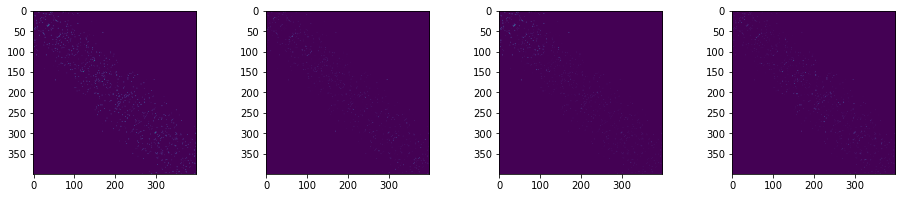

In [53]:
def make_scatters(ax,As):
    for t in range(len(As)):
        im = ax[t].imshow(As[t]);
        #plt.set_colorbar(im);
    return
        
f1,ax = plt.subplots(1,4,figsize=(16,3));
make_scatters(ax,[A,AA,AA2,A_random])

In [55]:
manage_opts = {'p':p, # decrease the edge weights of selected nodes by p% (p=1 is the strongest management) 
               'distributed':True # compute rankings separately for different subgraphs
              }
manage_opts['budget_step'] = K

rank_opts = {'type':'distributed_evec' # rank according to distributes eigenvector centrality
            }
b =  int(ceil(KK / K))
rank_opts['budget'] = np.repeat(b, K)

# independent management
rank_opts['info_id_sets'] = [np.array(i) for i in id_sets]
rank_opts['control_id_sets'] = [np.array(i) for i in id_sets]

manage_opts['online'] = True # update ranking after each modification? yes
AA3,lams3, Ks3 = manage_nodes(A,rank_opts,manage_opts)

manage_opts['online'] = False # update ranking after each modification? no
AA4,lams4, Ks4 = manage_nodes(A,rank_opts,manage_opts)


# info sharing -- community minded folks w global knowledge
rank_opts['info_id_sets'] = [np.arange(len(A)) for i in id_sets] # global knowledge (and care)
rank_opts['control_id_sets'] = [np.array(i) for i in id_sets]

manage_opts['online'] = True # update ranking after each modification? yes
AA5t,lams5t, Kst5 = manage_nodes(A,rank_opts,manage_opts)
AAt,lamst, Kst = manage_nodes(A,rank_opts,manage_opts)

manage_opts['online'] = False # update ranking after each modification? yes
AA6t,lams6t, Kst6 = manage_nodes(A,rank_opts,manage_opts)


# info sharing -- community minded w neighbor knowledge

id_sets_s = [np.array(i) for i in id_sets]
from functools import reduce
if K == 4:
    ids_4 = [reduce(np.union1d, id_sets_s[:2]),              
            reduce(np.union1d, id_sets_s[:3]),                             
             reduce(np.union1d, id_sets_s[1:4]),                  
             reduce(np.union1d, id_sets_s[2:4])
            ]
    rank_opts['info_id_sets'] = ids_4
if K == 8: 
    ids_8 = [reduce(np.union1d, id_sets_s[:2]),              
             reduce(np.union1d, id_sets_s[:3]),                             
             reduce(np.union1d, id_sets_s[1:4]),
             reduce(np.union1d, id_sets_s[2:5]),
             reduce(np.union1d, id_sets_s[3:6]),
             reduce(np.union1d, id_sets_s[4:7]),
             reduce(np.union1d, id_sets_s[5:8]),
             reduce(np.union1d, id_sets_s[6:8]),
            ]
    rank_opts['info_id_sets'] = ids_8
    
rank_opts['control_id_sets'] = [np.array(i) for i in id_sets]

manage_opts['online'] = True # update ranking after each modification? yes
AA7t, lams7t, Kst7 = manage_nodes(A,rank_opts,manage_opts)
AAt,lamst, Kst = manage_nodes(A,rank_opts,manage_opts)

manage_opts['online'] = False # update ranking after each modification? yes
AA8t,lams8t, Kst8 = manage_nodes(A,rank_opts,manage_opts)

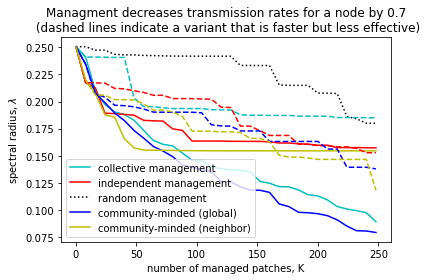

In [56]:
f1,ax = plt.subplots(1,1,figsize=(6,4));

plt.plot(Ks,lams,'c')
plt.plot(Ks3,lams3,'r')
plt.plot(Ksr,lams_random,'k:');
plt.plot(Kst5,lams5t,'b')
plt.plot(Kst7,lams7t,'y')

plt.legend(['collective management','independent management','random management', 'community-minded (global)', 'community-minded (neighbor)'])

plt.plot(Ks2,lams2,'c--')
plt.plot(Ks4,lams4,'r--');
plt.plot(Kst6,lams6t,'b--');
plt.plot(Kst8,lams8t,'y--')

plt.xlabel('number of managed patches, K')
plt.ylabel('spectral radius, $\lambda$')

plt.title('Managment decreases transmission rates for a node by '+ str(manage_opts['p']) +'\n (dashed lines indicate a variant that is faster but less effective)');
plt.tight_layout();
plt.savefig('figs/node_management_SBM'+str(K)+'.pdf')

We compare characteristics of independent to community-minded management

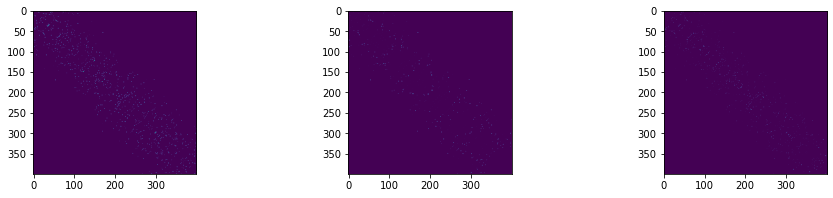

In [58]:
f1,ax = plt.subplots(1,3,figsize=(16,3));
# original A, AA3 indep, AA5 comm minded (all 'online')
make_scatters(ax,[A, AA3,AA5t])

In [24]:
def dist_impact(A):
    l, u = np.linalg.eigh(A)
    l_max_idx = np.argmax(l) # should be the last one at position len(l)-1
    u_max = u[:, l_max_idx]
    return [sum(u_max[i]) for i in id_sets] / sum(u_max)

In [28]:
import pandas as pd  # for formatting


data = [dist_impact(AA6t),
        dist_impact(AA8t),

        dist_impact(AA2),
        dist_impact(AA4),
        dist_impact(AA5t),
        dist_impact(AA7t),
        
        dist_impact(AA),
        dist_impact(AA3)
       ]
df = pd.DataFrame(data, columns=["mgr 1", "mgr 2", "mgr 3", "mgr 4"], 
            index=["non-online", "non-online", "non-online", "non-online", "online", "online", "online", "online"])
df['strategy'] = [
    "globally-informed community-minded",
        "neighbor-informed community-minded",

    "collective",
    "independent",
       "globally-informed community-minded",
            "neighbor-informed community-minded",

    "collective",
    "independent"
]
df[['strategy', 'mgr 1', 'mgr 2', 'mgr 3', 'mgr 4']].round(2)

,strategy,mgr 1,mgr 2,mgr 3,mgr 4
non-online,globally-informed community-minded,0.00,0.00,0.52,0.47
non-online,neighbor-informed community-minded,0.09,0.43,0.26,0.22
non-online,collective,0.00,0.02,0.33,0.65
non-online,independent,0.17,0.37,0.21,0.25
online,globally-informed community-minded,0.25,0.37,0.26,0.12
online,neighbor-informed community-minded,0.24,0.46,0.20,0.10
online,collective,0.33,0.50,0.12,0.05
online,independent,0.15,0.40,0.34,0.12


In [18]:
assert False

AssertionError: 

In [ ]:
lam_AA3 = np.max(np.linalg.eigh(AA3)[0])
print(SIS_opts['beta']/lam_AA3)

lam_AA5t = np.max(np.linalg.eigh(AA5t)[0])
print(SIS_opts['beta']/lam_AA5t)

Above are the two critical spreading rates $\gamma^*$ for the network after collective and individual management strategies, respectively. The difference will likely be largest just below the larger one, or at $\gamma=0.077$

### The spreading is almost 4 times as high for individual management versus collective management.

In [ ]:
SIS_opts['T'] = T * 11 # numnber of time steps
delay = T # how many time points to ignore before computing average activation
x0 = np.zeros(len(A),dtype=int)
x0[int(len(AA3)/2)] = 1
ps_AA3 = get_p_curve(AA3,SIS_opts,gammas,delay)

In [ ]:
ps_AA5t = get_p_curve(AA5t,SIS_opts,gammas,delay)

In [ ]:
ps_AA3 = ps_AA
f1,ax = plt.subplots(1,2,figsize=(12,4));
ax[0].loglog(gammas,ps,'b',linewidth=2)
ax[0].loglog(gammas,ps_AA3,'c',linewidth=2)
ax[0].loglog(gammas,ps_AA5t,'r',linewidth=2)
ax[0].legend(['unmanaged','collectively managed','independently managed'])
ax[0].set_title('Infected fraction at steady state')
ax[0].set_ylabel('steady state, $p$')
ax[0].set_xlabel('spreading rate, $\gamma$')
ax[0].plot([SIS_opts['beta']/lam,SIS_opts['beta']/lam],[.006,1],'b:')
ax[0].plot([SIS_opts['beta']/lam_AA3,SIS_opts['beta']/lam_AA3],[.006,1],'c:')
ax[0].plot([SIS_opts['beta']/lam_AA5t,SIS_opts['beta']/lam_AA5t],[.006,1],'r:')

ax[1].semilogx(gammas,ps_AA5t/ps_AA3,'k',linewidth=2)
ax[1].plot([SIS_opts['beta']/lam,SIS_opts['beta']/lam],[.006,1],'b:')
ax[1].plot([SIS_opts['beta']/lam_AA3,SIS_opts['beta']/lam_AA3],[.5,2],'c:')
ax[1].plot([SIS_opts['beta']/lam_AA5t,SIS_opts['beta']/lam_AA5t],[.5,2],'r:')
ax[1].set_title('Ratio of infections: independent vs collective management')
ax[1].set_ylabel('ratio, $\phi$')
ax[1].set_xlabel('spreading rate, $\gamma$')
plt.tight_layout();
ax[1].text(.01,1.6,s='Infection can be \ntwice as large \nwithout collective \nmanagement')
plt.savefig('figs/phase_transition.pdf')